In [6]:
import math
import pyvisa as visa
import re
import os 
import time

# Numerics and plotting
import ndfit
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import pandas as pd
from datetime import datetime

In [7]:
class HP4145A:

    def __init__(self, resource_name):
        """
        Initializes the driver with the VISA resource name of the instrument.
        Args:resource_name: The VISA resource name of the instrument (e.g., 'GPIB0::16::INSTR')
        """
        #self.instrument = pyvisa.ResourceManager().open_resource(resource_name)
        self.rm = visa.ResourceManager()
        print(self.rm.list_resources())
        self.instrument = self.rm.open_resource(resource_name)
        self.instrument.timeout = 30000 #30 sec timeout is in mSec
        self.instrument.read_termination = '\n'
        self.instrument.write_termination = '\n'
        self.instrument.write("*RST")
        self.instrument.write("IT1 CA1 DR0 BC") # set Integration time short, Auto Calibration ON, Data Ready OFF, Buffer Clear
        #print(dir(self.instrument)) #what attributes are available on the object

    def channelDefinition(self):
 
		## Select channel [DE]finition page
        self.instrument.write("DE")
        self.instrument.write("DE CH1,'VE','IE',3,3") ## Emitter Common constant
        self.instrument.write("DE CH2,'VB','IB',2,2") ## BASE SOURCE Current MODE VAR2 (VR2)
        self.instrument.write("DE CH3,'VC','IC',1,1") ## COLLECTOR SOURCE Voltage MODE VAR1 (VR1) Vary voltage 
       
        ## Turn off other channels 
        self.instrument.write("DE CH4")
        self.instrument.write("DE VS1")
        self.instrument.write("DE VS2")
        self.instrument.write("DE VM1")
        self.instrument.write("DE VM2")


    def sweepVoltage(self,start, stop, step,compliance):
		## Select [S]weep [S]etup page  
        self.instrument.write("SS")

        ## Set up the gate voltage variable. 
        CMD = "VR1,%s,%s,%s,%s"%(str(start).upper(), str(stop).upper(), str(step).upper(), str(compliance))
        self.instrument.write(CMD)
        self.number = np.abs(round((stop-start)/step,1))+1
        # print(f"VR1 start = {start}")
        # print(f"VR1 step = {step}")
        # print(f"VR! number = {self.number}")
        ## Return a list of the sweep variables
        return list(np.linspace(start,stop,int(self.number)))

    def stepCurrent(self,start,step,number,compliance):
			## Set up drain voltage setup
        self.instrument.write("SS")
        CMD = "IP %s,%s,%s,%s"%(str(start).upper(), str(step).upper(), str(number), str(compliance))
        # print(f"IP start = {start}")
        # print(f"IP step = {step}")
        # print(f"IP number of points = {number}")
        self.instrument.write(CMD)

    def setOutput(self):
		## Set up the list display. Note that if something is not in
		## the list we will not be able to request the data.
        # self.instrument.write("SM")  # measurement and display mode setup page
        # self.instrument.write("DM2")  # DM2 is List
        # self.instrument.write("LI 'IC'")
        # self.instrument.write("'IB' 'IC'")
        self.instrument.write("SM DM2 LI 'IC','IB','VB'")

		## Pack the independent parameter into a list and return it
		#current = list(np.linspace(start, stop, int((stop-start)/(step)), endpoint=False))
		#current.append(stop)
		#return current

    def measureData(self):
		## Issue command to [M]easure [D]ata
        self.instrument.write("MD ME1")
		## Pause for the 4145B to populate the buffer with measurement
		## data. If there is no sleep, Python will issue the ask commend
		## before the measurement has been complete

    def getDataIC(self):
        #time.sleep(2)
        ## Request data and transform it in to a list by splitting 
        ## on regular expression. Note that the slice operation is 
        ## needed because the first item in the list after re.split
        ## is the empty string.
        data = re.split(',*[NXCT]\s*', self.instrument.query("DO 'IC'"))[1:] 
        return [float(i) for i in data]
	
    def getDataVB(self):
        #time.sleep(2)
        ## Request data and transform it in to a list by splitting 
        ## on regular expression. Note that the slice operation is 
        ## needed because the first item in the list after re.split
        ## is the empty string.
        data = re.split(',*[NXCT]\s*', self.instrument.query("DO 'VB'"))[1:] 
        return [float(i) for i in data]
    
    def getDataIE(self):
        #time.sleep(2)
        ## Request data and transform it in to a list by splitting 
        ## on regular expression. Note that the slice operation is 
        ## needed because the first item in the list after re.split
        ## is the empty string.
        data = re.split(',*[NXCT]\s*', self.instrument.query("DO 'IE'"))[1:] 
        return [float(i) for i in data]
    
    def captureData(self,variable):
        time.sleep(2)
        ## Request data and transform it in to a list by splitting 
        ## on regular expression. Note that the slice operation is 
        ## needed because the first item in the list after re.split
        ## is the empty string.
        data = re.split(',*[NXCT]\s*', self.instrument.query(f"DO '{variable}'"))[1:] 
        return [float(i) for i in data]

In [8]:
## Useful Generator Function 
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i+n]


In [9]:
resource_name = 'GPIB0::19::INSTR'  # Replace with your instrument's VISA resource name
spa = HP4145A(resource_name)

('ASRL1::INSTR', 'ASRL2::INSTR', 'GPIB0::19::INSTR')


Channel Definition

In [10]:
spa.instrument.write("DE")
spa.instrument.write("DE CH1,'VB','IB',2,2") ## BASE SOURCE Current MODE VAR2 (VR2)
spa.instrument.write("DE CH4,'VE','IE',3,3") ## Emitter Common constant
spa.instrument.write("DE CH3,'VC','IC',1,1") ## COLLECTOR SOURCE Voltage MODE VAR1 (VR1) Vary voltage 

## Turn off other channels 
spa.instrument.write("DE CH2")
spa.instrument.write("DE VS1")
spa.instrument.write("DE VS2")
spa.instrument.write("DE VM1")
spa.instrument.write("DE VM2")

7

In [11]:
# VC_start = 0
# VC_stop = 5.0
# VC_step = 0.01
# VC_number = int((VC_stop-VC_start)/(VC_step))+1
# VC_list = list(np.linspace(VC_start,VC_stop,VC_number))
# print (f'VC_list = {["{0:0.3f}".format(i) for i in VC_list]}')
# print(f'VC_List length = {len(VC_list)}')
# IB_start = 20E-6
# IB_stop = 100E-6
# IB_step = 100E-6
# IB_number = int((IB_stop-IB_start)/(IB_step)) + 1
# IB_list = list(np.linspace(IB_start,IB_stop,IB_number))
# print (f'IB_list = {["{0:0.3e}".format(i) for i in IB_list]}')
# print(f'IB_List length = {len(IB_list)}')
# ibx = list(np.linspace(IB_start,IB_stop,IB_number)) 

SOURCE SETUP

In [12]:
# VCE = spa.sweepVoltage(VC_start,VC_stop,VC_step,100e-3) # setup sweep start, stop, step,compliance VR1
# spa.stepCurrent(IB_start,IB_step,5,2) # start step number compliance

LIST SETUP

In [13]:
spa.instrument.write("SM DM2 LI 'IC'")

15

GRAPHICS SETUP

In [14]:
spa.instrument.write("SM DM1 XN 'VC',1,0,10;YA 'IC',1,0,0.05")

39

VC_List length = 51
IB_list = ['2.000e-06']
IB_List length = 1
chunk_size = 501
IB = 0.000002
vc_list_length = 51
    VC        IB        IC
0  0.0  0.000002 -0.000002
1  0.1  0.000002  0.000195
2  0.2  0.000002  0.000369
3  0.3  0.000002  0.000377
Saving data to Filename: 2025_03_17-07_58_33_AM_IC.csv


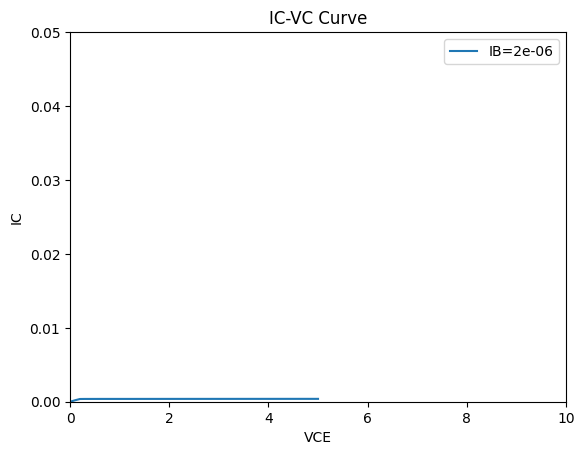

In [15]:
VC_start = 0
VC_stop = 5.0 #10
VC_step = 0.001 #0.001
VC_number = int((VC_stop-VC_start)/(VC_step))+1
VC_list = list(np.linspace(VC_start,VC_stop,VC_number))
#print (f'VC_list = {["{0:0.3f}".format(i) for i in VC_list]}')
print(f'VC_List length = {len(VC_list)}')
IB_start = 1E-6 # change this back to 1E-6
IB_stop = 100E-6 #100E-6
IB_step = 1E-6 #1E-6
IB_number = int((IB_stop-IB_start)/(IB_step)) + 1
IB_list = list(np.linspace(IB_start,IB_stop,IB_number))
print (f'IB_list = {["{0:0.3e}".format(i) for i in IB_list]}')
print(f'IB_List length = {len(IB_list)}')
my_array = np.empty((0, 3), dtype=float)
my_array1 = np.empty((0, 3), dtype=float)
chunk_size = 501
print(f'chunk_size = {chunk_size}')
#spa.instrument.write("SM DM2 LI 'IC'")
## we have to extract data 501 numbers at a time - this is howmuch the machine can work  and do this for each Ib value
for n,ib in enumerate(IB_list): # this is outer loop for each of this we can only get upto 501 data at time
    print ("%s %f"%("IB =", ib))
    #print(f'chunk_size= {chunk_size}')
    for i in range(0, len(VC_list), chunk_size):
        vc_list = VC_list[i:i+chunk_size]
        this_chunk_length = len(vc_list)
        vc_start = VC_list[i]
        vc_stop = VC_list[i+this_chunk_length-1]
        vc_step = VC_step
        # print(f'vc_start = {vc_start}')
        # print(f'vc_stop = {vc_stop}')
        print(f'vc_list_length = {this_chunk_length}')
        VC = spa.sweepVoltage(vc_start,vc_stop,vc_step,100e-3) 
        spa.stepCurrent(ib,IB_step,1,2) #start,step,number,compliance
        spa.instrument.write("SM DM2 LI 'IC'") # List setup
        spa.instrument.write("MD ME1") # measure data
        time.sleep(8)
        IC = spa.getDataIC() # produces len number floating point list at a time
        #VB = spa.getDataVB()
        #IE = spa.getDataIE()
        #print (f'IC = {["{0:0.3E}".format(i) for i in IC]}')
        # print(f'IC length = {len(IC)}')
        IB= [ib] * len(VC)
        # print(f'IB length = {len(IB)}')
        for row in zip(VC,IB,IC):
            my_array = np.vstack([my_array, row])
        for row in zip(VC,IB,IC):
            my_array1 = np.vstack([my_array1, row])
        # print(my_array.shape)
        # print(len(my_array1))
    plt.plot(my_array1[:,0], my_array1[:,2], label =f'IB={ib}')
    my_array1 = np.empty((0, 3), dtype=float)
    plt.xlim([0, 10])
    plt.ylim([0.0, 0.050])
    plt.xlabel("VCE")
    plt.ylabel("IC")
    plt.title('IC-VC Curve')
    plt.legend()
    

saveData=np.array(my_array)
df = pd.DataFrame(saveData, columns=['VC','IB','IC'])
print(df.head(4))
filename1 = datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")
filename = filename1+'_IC.csv'
df.to_csv(filename, index=False, float_format='%.6E')
df.to_csv("filename", index=False)
print(f"Saving data to Filename: {filename}")

PLOT DATA

In [ ]:
saveData=np.array(my_array)
df = pd.DataFrame(saveData, columns=['VC','IB','IC'])
#df = df['IE']
print(df.head(4))
filename1 = datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")
filename = filename1+'_IC.csv'
#df.to_csv(filename, index=False, float_format='%.6E')
df.to_csv(filename, index=False)
print(f"Saving data to Filename: {filename}")

In [ ]:
# print(my_array[:,1])
# plt.plot(my_array[:,0], my_array[:,2], label =f'IB={ib}')
# plt.xlim([0, 10])
# plt.ylim([0, 0.050])
# plt.xlabel("VCE")
# plt.ylabel("IC")
# plt.legend()
# plt.title('IV Curve')

# plt.plot(my_array[:,0], my_array[:,2], label =f'IB={ib}')
# my_array1 = np.empty((0, 3), dtype=float)
# plt.xlim([0, 10])
# plt.ylim([0, 0.050])
# plt.xlabel("VCE")
# plt.ylabel("IC")
# plt.title('IV Curve')
# plt.legend()

saveData=np.array(my_array)
df = pd.DataFrame(saveData, columns=['VC','IB','IC'])
print(df.head(4))
filename1 = datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")
filename = filename1+'_IC.csv'
#df.to_csv(filename, index=False, float_format='%.6E')
df.to_csv(filename, index=False)
print(f"Saving data to Filename: {filename}")


# ax1.set_ylim(0.0, max(IC)+0.001)
# #ax2.set_ylim(0.0, max(g0)+100)
# ax1.set_xlabel(r"Drain Voltage $(V_d)$")
# ax1.set_ylabel(r"Drain Current $(I_d)$")
# #ax2.set_ylabel(r"Output Conductance $(g_0)$")

# ## Fancy Colorbar
# cmap = mpl.cm.cool
# norm = mpl.colors.Normalize(min(ibx),max(ibx))
# #ax2 = fig.add_axes([0.90, 0.1, 0.03, 0.8])
# # cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,
# #                         norm=norm,
# #                         orientation='vertical')

# # cb1.set_label(r"Gate Voltage $(V_g)$")
# plt.show()

In [ ]:
# spa.instrument.write("*RST")
# spa.instrument.close()
#spa.instrument.write("US")
spa.rm.close()